# Import dependencies

In [8]:
import pandas as pd
from plot import line_plot
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from models import SIR,SIRD,SIRF,SIRFV
from prediction import Predicter
from simulator import simulation
from datetime import timedelta
import numpy as np
from estimator import Estimater
from utilities import select_area, show_trend, create_target_df
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

# Pre-processing raw data

In [9]:
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

raw = pd.read_csv("./data/covid_19_data.csv")
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)

ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(int)
ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]
print(ncov_df.tail())
print(ncov_df.info())
ncov_df.describe(include="all").fillna("-")
pd.DataFrame(ncov_df.isnull().sum()).T
", ".join(ncov_df["Country"].unique().tolist())

           Date                         Country                      Province  \
5627 2020-03-14                              US          Virgin Islands, U.S.   
5628 2020-03-14                              UK                     Gibraltar   
5629 2020-03-14                       Australia  Diamond Princess cruise ship   
5630 2020-03-14                              US                 West Virginia   
5631 2020-03-14  occupied Palestinian territory                             -   

      Infected  Deaths  Recovered  
5627         1       0          0  
5628         0       0          1  
5629         0       0          0  
5630         0       0          0  
5631         0       0          0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5632 entries, 0 to 5631
Data columns (total 6 columns):
Date         5632 non-null datetime64[ns]
Country      5632 non-null object
Province     5632 non-null object
Infected     5632 non-null int64
Deaths       5632 non-null int64
Recovered    56

'China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia, Slovaki

# Visualize data for the world

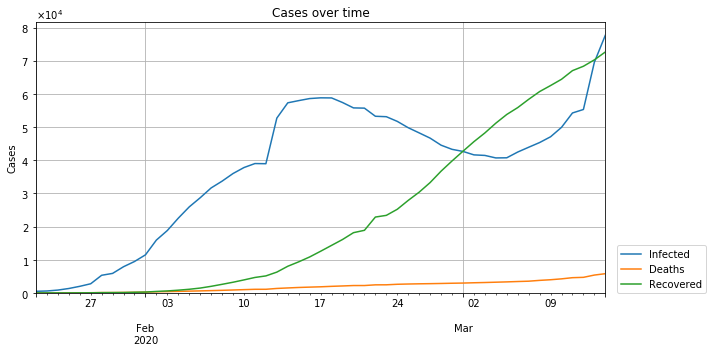

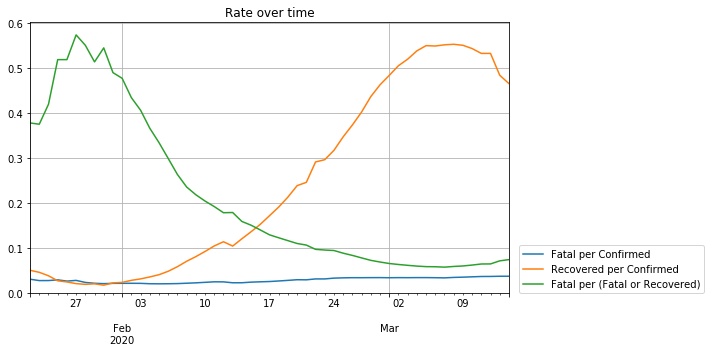

In [10]:
total_df = ncov_df.groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
pd.plotting.register_matplotlib_converters()
line_plot(total_df[data_cols], title="Cases over time")
line_plot(total_df[rate_cols], "Rate over time", ylabel="", math_scale=False)
plt.show()

# Visualize data for Norway

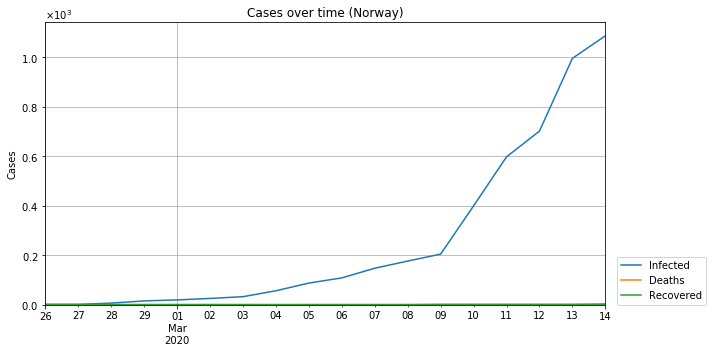

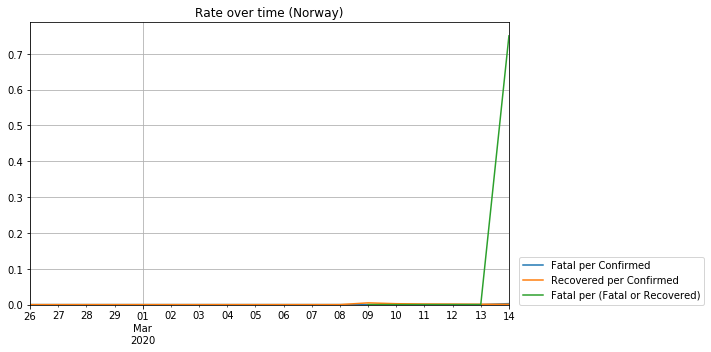

In [11]:
total_df = ncov_df.loc[ncov_df["Country"] == "Norway", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()
line_plot(total_df[data_cols], title="Cases over time (Norway)")
line_plot(total_df[rate_cols], "Rate over time (Norway)", ylabel="", math_scale=False)
plt.show()

In [12]:
population_date = "15Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
    "Norway":"5,421,241",
    "India": "1,380,004,385",
    "USA": "331,002,647",

}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran,Norway,India,USA
Total population on 15Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953,5421241,1380004385,331002647


# Prediction with SIR model

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

 * S: Susceptible (=All - Confirmed)
 * I: Infected (=Confirmed - Recovered - Deaths)
 * R: Recovered or Died (=Recovered + Deaths)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or Died". This is because mortality rate cannot be ignored in the real data of COVID-19.

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, the units of the variables should be removed from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$  

Basic reproduction number, Non-dimentional parameter, is defined as  
$R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}$  

Estimated Mean Values of $R_0$:  
$R_0$ means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova
1.5 : Spring wave of 1918 Spanish influenza in Genova

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$. This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.

In [13]:
train_dataset = SIR.create_dataset(
    ncov_df, population_dict["Global"] - population_dict["China"], excluded_places=[("China", None)]
)
train_start_date, train_initials, train_Tend, train_df = train_dataset
print([train_start_date.strftime(time_format), train_initials, train_Tend])

['22Jan2020 00:00', array([9.99999999e-01, 1.25875722e-09, 0.00000000e+00]), 74880]


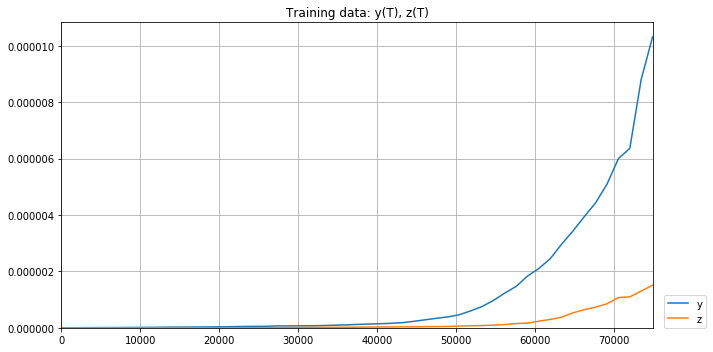

In [14]:
line_plot(
    train_df.set_index("T").drop("x", axis=1),
    "Training data: y(T), z(T)", math_scale=False, ylabel=""
)

**Note: We cannot convert $T$ to $t$ because $\tau$ has not been determined yet.**

### Example of non-dimensional SIR model
For example, set $R_0 = 2.5, \rho=0.2$.

In [15]:
eg_r0, eg_rho = (2.5, 0.2)
eg_sigma = eg_rho / eg_r0

In [16]:
%%time
eg_df = simulation(SIR, train_initials, step_n=300, rho=eg_rho, sigma=eg_sigma)
eg_df.tail()

CPU times: user 9.79 ms, sys: 84 µs, total: 9.88 ms
Wall time: 10.1 ms


,t,x,y,z
296,296,0.108343,0.000628,0.891029
297,297,0.108330,0.000592,0.891078
298,298,0.108317,0.000559,0.891124
299,299,0.108306,0.000527,0.891167
300,300,0.108295,0.000497,0.891208


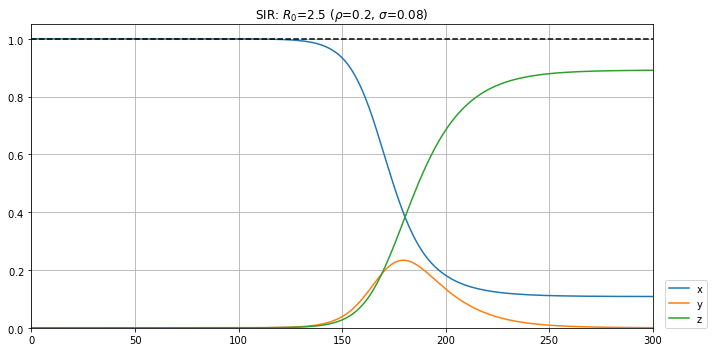

In [17]:
line_plot(
    eg_df.set_index("t"),
    title=r"SIR: $R_0$={0} ($\rho$={1}, $\sigma$={2})".format(eg_r0, eg_rho, eg_sigma),
    ylabel="",
    h=1
)

### Test of hyperparameter optimization using example data
To test the hyperparameter optimization functions defeined in this notebook, we will estimate the SIR model parameters using the example data and example $\tau=1440$ [min] and total population 1,000,000.

In [18]:
# Set the example conditions
eg_tau = 1440
eg_start_date = ncov_df["Date"].min()
eg_total_population = 1000000
# Create dataset in the format of ncov_df
eg_ori_df = pd.DataFrame(
    {
        "Date": (eg_df["t"] * eg_tau).apply(lambda x: timedelta(minutes=x)) + eg_start_date,
        "Country": "Example",
        "Province": "Example"
    }
)
eg_ori_df["Infected"] = (eg_df["y"] * eg_total_population).astype(int)
eg_ori_df["Deaths"] = (eg_df["z"] * eg_total_population * 0.02).astype(int)
eg_ori_df["Recovered"] = (eg_df["z"] * eg_total_population * 0.98).astype(int)
eg_ori_df.tail()

,Date,Country,Province,Infected,Deaths,Recovered
296,2020-11-13,Example,Example,627,17820,873208
297,2020-11-14,Example,Example,592,17821,873256
298,2020-11-15,Example,Example,558,17822,873301
299,2020-11-16,Example,Example,526,17823,873344
300,2020-11-17,Example,Example,497,17824,873384


### Hyperparameter optimization
Using Optuna package, ($\rho, \sigma, \tau$) will be estimated by model fitting.

In [19]:
%%time
sir_estimater = Estimater(
    SIR, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sir_dict = sir_estimater.run()

[I 2020-03-16 00:40:52,974] Finished trial#2 resulted in value: 8234668024.905892. Current best value is 8234668024.905892 with parameters: {'tau': 818, 'rho': 0.09519866243202438, 'sigma': 0.011504664234090611}.
[I 2020-03-16 00:40:53,046] Finished trial#3 resulted in value: 8108548699.670739. Current best value is 8108548699.670739 with parameters: {'tau': 788, 'rho': 0.095039326662604, 'sigma': 0.0060835360587643775}.
[I 2020-03-16 00:40:53,137] Finished trial#1 resulted in value: 10092004389.366447. Current best value is 8108548699.670739 with parameters: {'tau': 788, 'rho': 0.095039326662604, 'sigma': 0.0060835360587643775}.
[I 2020-03-16 00:40:53,215] Finished trial#0 resulted in value: 20009588708.255833. Current best value is 8108548699.670739 with parameters: {'tau': 788, 'rho': 0.095039326662604, 'sigma': 0.0060835360587643775}.
[I 2020-03-16 00:40:53,362] Finished trial#6 resulted in value: 9461828546.50687. Current best value is 8108548699.670739 with parameters: {'tau': 78

[I 2020-03-16 00:40:57,316] Finished trial#38 resulted in value: 4161745249.896011. Current best value is 3716231717.2740664 with parameters: {'tau': 1423, 'rho': 0.1986012717101376, 'sigma': 0.02540495973721922}.
[I 2020-03-16 00:40:57,515] Finished trial#40 resulted in value: 5117141239.560789. Current best value is 3716231717.2740664 with parameters: {'tau': 1423, 'rho': 0.1986012717101376, 'sigma': 0.02540495973721922}.
[I 2020-03-16 00:40:57,516] Finished trial#39 resulted in value: 3810383356.485408. Current best value is 3716231717.2740664 with parameters: {'tau': 1423, 'rho': 0.1986012717101376, 'sigma': 0.02540495973721922}.
[I 2020-03-16 00:40:57,698] Finished trial#43 resulted in value: 3808721757.2984934. Current best value is 3716231717.2740664 with parameters: {'tau': 1423, 'rho': 0.1986012717101376, 'sigma': 0.02540495973721922}.
[I 2020-03-16 00:40:57,857] Finished trial#41 resulted in value: 7312918403.055829. Current best value is 3716231717.2740664 with parameters: {

[I 2020-03-16 00:41:02,067] Finished trial#78 resulted in value: 3705939762.603265. Current best value is 3622104369.3095217 with parameters: {'tau': 1409, 'rho': 0.1983530377438029, 'sigma': 0.023858219108390654}.
[I 2020-03-16 00:41:02,161] Finished trial#76 resulted in value: 3840513193.434874. Current best value is 3622104369.3095217 with parameters: {'tau': 1409, 'rho': 0.1983530377438029, 'sigma': 0.023858219108390654}.
[I 2020-03-16 00:41:02,303] Finished trial#79 resulted in value: 3952294073.2541676. Current best value is 3622104369.3095217 with parameters: {'tau': 1409, 'rho': 0.1983530377438029, 'sigma': 0.023858219108390654}.
[I 2020-03-16 00:41:02,407] Finished trial#73 resulted in value: 10883984733.346533. Current best value is 3622104369.3095217 with parameters: {'tau': 1409, 'rho': 0.1983530377438029, 'sigma': 0.023858219108390654}.
[I 2020-03-16 00:41:02,521] Finished trial#81 resulted in value: 3899275004.638578. Current best value is 3622104369.3095217 with paramete

[I 2020-03-16 00:41:06,818] Finished trial#112 resulted in value: 5718304912.204434. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:06,970] Finished trial#117 resulted in value: 3674066504.2080736. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:07,063] Finished trial#118 resulted in value: 4038516875.0143347. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:07,128] Finished trial#116 resulted in value: 3702431380.528345. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:07,311] Finished trial#119 resulted in value: 3877852498.07624. Current best value is 3577085565.8314285 with paramete

[I 2020-03-16 00:41:11,502] Finished trial#154 resulted in value: 3706347766.7598014. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:11,609] Finished trial#153 resulted in value: 3970124945.7420287. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:11,724] Finished trial#155 resulted in value: 3719686062.597747. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:11,879] Finished trial#156 resulted in value: 3700898699.0905023. Current best value is 3577085565.8314285 with parameters: {'tau': 1374, 'rho': 0.19560676763100363, 'sigma': 0.0243944127238423}.
[I 2020-03-16 00:41:12,076] Finished trial#157 resulted in value: 3889871820.750554. Current best value is 3577085565.8314285 with parame

[I 2020-03-16 00:41:16,665] Finished trial#190 resulted in value: 3701151800.771355. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:16,860] Finished trial#180 resulted in value: 8818069943.878231. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:17,023] Finished trial#194 resulted in value: 4237560174.1282496. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:17,144] Finished trial#192 resulted in value: 10746600288.29695. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:17,247] Finished trial#183 resulted in value: 9851335618.825312. Current best value is 3542557051.682581 with param

[I 2020-03-16 00:41:21,575] Finished trial#229 resulted in value: 3971799963.011926. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:21,681] Finished trial#226 resulted in value: 3960373740.038687. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:21,826] Finished trial#228 resulted in value: 3985934412.4003024. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:21,924] Finished trial#227 resulted in value: 3859259003.6028223. Current best value is 3542557051.682581 with parameters: {'tau': 1407, 'rho': 0.19671662677056365, 'sigma': 0.023813386702066244}.
[I 2020-03-16 00:41:22,045] Finished trial#230 resulted in value: 5024352031.058312. Current best value is 3542557051.682581 with para

[I 2020-03-16 00:41:26,376] Finished trial#265 resulted in value: 3670456493.7598906. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:26,506] Finished trial#263 resulted in value: 6559831012.808613. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:26,647] Finished trial#267 resulted in value: 3703825239.6227913. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:26,755] Finished trial#264 resulted in value: 6099508081.720561. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:26,869] Finished trial#266 resulted in value: 4248588404.4696836. Current best value is 3463470438.6616726 with pa

[I 2020-03-16 00:41:31,810] Finished trial#300 resulted in value: 3937430851.681912. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:32,010] Finished trial#288 resulted in value: 11110594456.004765. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:32,277] Finished trial#301 resulted in value: 10920246356.65159. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:32,425] Finished trial#306 resulted in value: 3972922712.9883466. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:32,571] Finished trial#304 resulted in value: 10955587923.591295. Current best value is 3463470438.6616726 with pa

[I 2020-03-16 00:41:38,682] Finished trial#339 resulted in value: 4648522680.121782. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:38,813] Finished trial#334 resulted in value: 9978636939.061039. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:38,928] Finished trial#335 resulted in value: 7036346686.900896. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:39,232] Finished trial#340 resulted in value: 4110755435.6515527. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:39,384] Finished trial#342 resulted in value: 3767214736.4586825. Current best value is 3463470438.6616726 with par

[I 2020-03-16 00:41:45,400] Finished trial#374 resulted in value: 4690459958.534285. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:45,507] Finished trial#375 resulted in value: 4662794704.430005. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:45,705] Finished trial#376 resulted in value: 9183663771.969885. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:45,820] Finished trial#378 resulted in value: 3773932228.995524. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:45,890] Finished trial#379 resulted in value: 3674458082.887245. Current best value is 3463470438.6616726 with param

[I 2020-03-16 00:41:51,129] Finished trial#413 resulted in value: 3777341785.483038. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:51,291] Finished trial#405 resulted in value: 8951386773.730623. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:51,442] Finished trial#414 resulted in value: 3786304182.757547. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:51,636] Finished trial#416 resulted in value: 4912234657.308286. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:51,759] Finished trial#415 resulted in value: 3944764250.4880733. Current best value is 3463470438.6616726 with para

[I 2020-03-16 00:41:57,438] Finished trial#450 resulted in value: 9502946105.966433. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:57,615] Finished trial#449 resulted in value: 9564670237.429186. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:57,788] Finished trial#452 resulted in value: 4029410484.1130857. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:57,897] Finished trial#451 resulted in value: 6363647635.632178. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:41:58,084] Finished trial#453 resulted in value: 4049490407.2869415. Current best value is 3463470438.6616726 with par

[I 2020-03-16 00:42:04,813] Finished trial#486 resulted in value: 4111172448.0193233. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:42:04,973] Finished trial#489 resulted in value: 4044982496.433548. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:42:05,141] Finished trial#490 resulted in value: 4298067326.986812. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:42:05,286] Finished trial#470 resulted in value: 8765218280.676142. Current best value is 3463470438.6616726 with parameters: {'tau': 1407, 'rho': 0.1985651209291055, 'sigma': 0.023302393878844026}.
[I 2020-03-16 00:42:05,456] Finished trial#492 resulted in value: 4046483046.687705. Current best value is 3463470438.6616726 with para

CPU times: user 1min 13s, sys: 4.52 s, total: 1min 18s
Wall time: 1min 14s


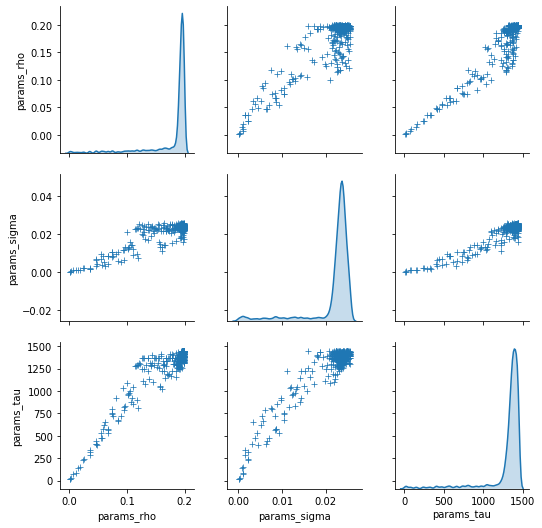

/home/adil/Dropbox/Courses/BigdataCybernetics/TTK4260/E11/CoronaVirus/estimator.py:157: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



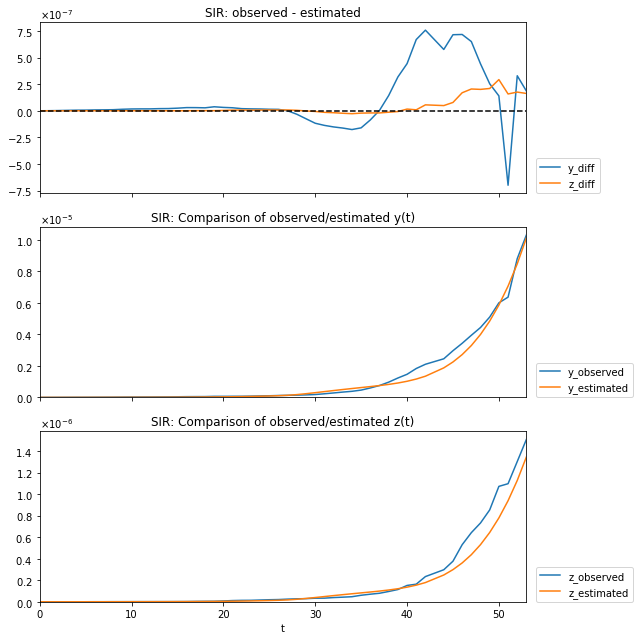

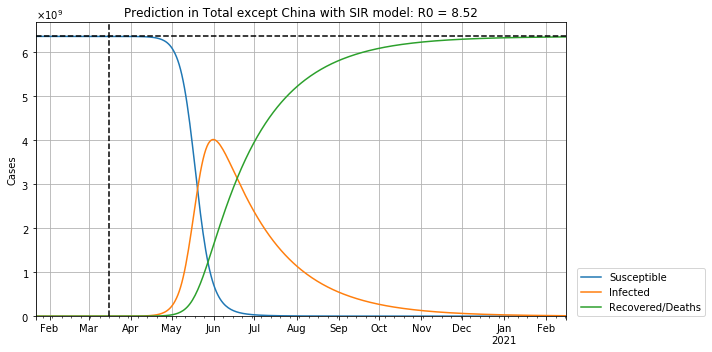

In [20]:
sir_estimater.history_df().head()
sir_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict}, orient="index")
sir_estimater.compare_graph()
sir_estimater.predict_graph(step_n=400)

## Prediction with SIR-D model
Because we can measure the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?
* S: Susceptible
* I: Infected
* R: Recovered
* D: Fatal

Model:  
S + I $\overset{\beta}{\longrightarrow}$ 2I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha}{\longrightarrow}$ D  

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I$  

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \kappa, \rho, \sigma) < 1$  
$1\leq \tau \leq 1440$

Reproduction number can be defined as  
$R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [21]:
%%time
sird_estimater = Estimater(
    SIRD, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sird_dict = sird_estimater.run()

[I 2020-03-16 00:42:11,766] Finished trial#1 resulted in value: 83546467040.30966. Current best value is 83546467040.30966 with parameters: {'tau': 1180, 'kappa': 0.0024030647948533935, 'rho': 0.14263956031503375, 'sigma': 0.017930169081539528}.
[I 2020-03-16 00:42:11,855] Finished trial#3 resulted in value: 115817472231.43053. Current best value is 83546467040.30966 with parameters: {'tau': 1180, 'kappa': 0.0024030647948533935, 'rho': 0.14263956031503375, 'sigma': 0.017930169081539528}.
[I 2020-03-16 00:42:11,937] Finished trial#2 resulted in value: 67295278604.30789. Current best value is 67295278604.30789 with parameters: {'tau': 1375, 'kappa': 0.0027285789734328237, 'rho': 0.1776520777697923, 'sigma': 0.008670796271270223}.
[I 2020-03-16 00:42:12,008] Finished trial#0 resulted in value: 118697241191.35222. Current best value is 67295278604.30789 with parameters: {'tau': 1375, 'kappa': 0.0027285789734328237, 'rho': 0.1776520777697923, 'sigma': 0.008670796271270223}.
[I 2020-03-16 00

[I 2020-03-16 00:42:15,554] Finished trial#31 resulted in value: 120271427618.32251. Current best value is 49581612599.72365 with parameters: {'tau': 1272, 'kappa': 0.0030660082728589575, 'rho': 0.18425411661402144, 'sigma': 0.02015360126921291}.
[I 2020-03-16 00:42:15,683] Finished trial#35 resulted in value: 151416790003.34927. Current best value is 49581612599.72365 with parameters: {'tau': 1272, 'kappa': 0.0030660082728589575, 'rho': 0.18425411661402144, 'sigma': 0.02015360126921291}.
[I 2020-03-16 00:42:15,829] Finished trial#37 resulted in value: 81805870104.47388. Current best value is 49581612599.72365 with parameters: {'tau': 1272, 'kappa': 0.0030660082728589575, 'rho': 0.18425411661402144, 'sigma': 0.02015360126921291}.
[I 2020-03-16 00:42:15,934] Finished trial#36 resulted in value: 91616760370.12715. Current best value is 49581612599.72365 with parameters: {'tau': 1272, 'kappa': 0.0030660082728589575, 'rho': 0.18425411661402144, 'sigma': 0.02015360126921291}.
[I 2020-03-16 

[I 2020-03-16 00:42:20,299] Finished trial#65 resulted in value: 45829978810.87758. Current best value is 40879449549.1774 with parameters: {'tau': 1437, 'kappa': 0.00252220769366082, 'rho': 0.19812860453734585, 'sigma': 0.0202035540459735}.
[I 2020-03-16 00:42:20,452] Finished trial#67 resulted in value: 45260358118.05213. Current best value is 40879449549.1774 with parameters: {'tau': 1437, 'kappa': 0.00252220769366082, 'rho': 0.19812860453734585, 'sigma': 0.0202035540459735}.
[I 2020-03-16 00:42:20,551] Finished trial#68 resulted in value: 42245552537.68074. Current best value is 40879449549.1774 with parameters: {'tau': 1437, 'kappa': 0.00252220769366082, 'rho': 0.19812860453734585, 'sigma': 0.0202035540459735}.
[I 2020-03-16 00:42:20,713] Finished trial#69 resulted in value: 70311474723.19357. Current best value is 40879449549.1774 with parameters: {'tau': 1437, 'kappa': 0.00252220769366082, 'rho': 0.19812860453734585, 'sigma': 0.0202035540459735}.
[I 2020-03-16 00:42:20,861] Fini

[I 2020-03-16 00:42:24,971] Finished trial#102 resulted in value: 39696570035.53935. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:25,154] Finished trial#98 resulted in value: 122919846307.15128. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:25,253] Finished trial#103 resulted in value: 109614119134.05981. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:25,422] Finished trial#104 resulted in value: 41167248223.76817. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 

[I 2020-03-16 00:42:29,741] Finished trial#134 resulted in value: 40422328002.76194. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:29,956] Finished trial#135 resulted in value: 39411210760.572014. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:30,181] Finished trial#117 resulted in value: 205718877073.93094. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:30,478] Finished trial#137 resulted in value: 41598669709.21675. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I

[I 2020-03-16 00:42:35,639] Finished trial#165 resulted in value: 39382006638.70156. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:35,814] Finished trial#163 resulted in value: 118539424707.15428. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:35,814] Finished trial#164 resulted in value: 62074464728.820114. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:36,065] Finished trial#166 resulted in value: 44975418281.17446. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I

[I 2020-03-16 00:42:39,687] Finished trial#196 resulted in value: 53648747590.45131. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:39,785] Finished trial#192 resulted in value: 117580180827.33376. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:39,924] Finished trial#197 resulted in value: 41414818437.05019. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:40,020] Finished trial#198 resulted in value: 41579381463.614876. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I

[I 2020-03-16 00:42:44,122] Finished trial#227 resulted in value: 41055130778.43292. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:44,254] Finished trial#229 resulted in value: 42842786747.40387. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:44,389] Finished trial#230 resulted in value: 40696396510.482506. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:44,523] Finished trial#231 resulted in value: 39854960985.5517. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2

[I 2020-03-16 00:42:49,134] Finished trial#262 resulted in value: 43301204837.30878. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:49,290] Finished trial#263 resulted in value: 45702387029.84539. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:49,444] Finished trial#260 resulted in value: 103727685905.69975. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:49,547] Finished trial#264 resulted in value: 42154001831.51676. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 

[I 2020-03-16 00:42:54,155] Finished trial#294 resulted in value: 39781054783.562584. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:54,290] Finished trial#283 resulted in value: 116005691595.25748. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:54,443] Finished trial#295 resulted in value: 39995933172.820694. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:54,597] Finished trial#296 resulted in value: 44070117128.70158. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[

[I 2020-03-16 00:42:59,672] Finished trial#324 resulted in value: 52602911513.61788. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:59,844] Finished trial#325 resulted in value: 39866572906.74006. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:42:59,949] Finished trial#326 resulted in value: 46987711964.15961. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:00,114] Finished trial#327 resulted in value: 44841560913.1247. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 20

[I 2020-03-16 00:43:04,613] Finished trial#355 resulted in value: 56961010072.17583. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:04,817] Finished trial#359 resulted in value: 44561002057.44222. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:04,994] Finished trial#360 resulted in value: 45447898510.16831. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:05,169] Finished trial#361 resulted in value: 44891640787.98223. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2

[I 2020-03-16 00:43:10,014] Finished trial#388 resulted in value: 44707496630.265076. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:10,088] Finished trial#387 resulted in value: 55878562977.99925. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:10,158] Finished trial#389 resulted in value: 45008270233.99444. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 2020-03-16 00:43:10,374] Finished trial#390 resulted in value: 46947587757.23283. Current best value is 39134031987.861336 with parameters: {'tau': 1406, 'kappa': 0.0023061696702097703, 'rho': 0.19493168495948143, 'sigma': 0.019328862186204956}.
[I 

[I 2020-03-16 00:43:15,099] Finished trial#422 resulted in value: 48917237228.68634. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:15,277] Finished trial#423 resulted in value: 43706574452.19218. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:15,455] Finished trial#424 resulted in value: 44126384946.51909. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:16,024] Finished trial#406 resulted in value: 104676181021.829. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16

[I 2020-03-16 00:43:21,288] Finished trial#455 resulted in value: 59826723067.863075. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:21,477] Finished trial#427 resulted in value: 108106552932.67036. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:21,826] Finished trial#457 resulted in value: 88985936348.44328. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:22,010] Finished trial#458 resulted in value: 39656996299.43768. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03

[I 2020-03-16 00:43:27,999] Finished trial#487 resulted in value: 42099756363.10031. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:28,170] Finished trial#488 resulted in value: 43877922390.19091. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:28,350] Finished trial#489 resulted in value: 57554713048.87295. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-16 00:43:28,473] Finished trial#490 resulted in value: 75844804979.24979. Current best value is 38102826352.051025 with parameters: {'tau': 1407, 'kappa': 0.0017466325873181198, 'rho': 0.19682489182084364, 'sigma': 0.0196050776880719}.
[I 2020-03-1

CPU times: user 1min 18s, sys: 4.42 s, total: 1min 23s
Wall time: 1min 18s


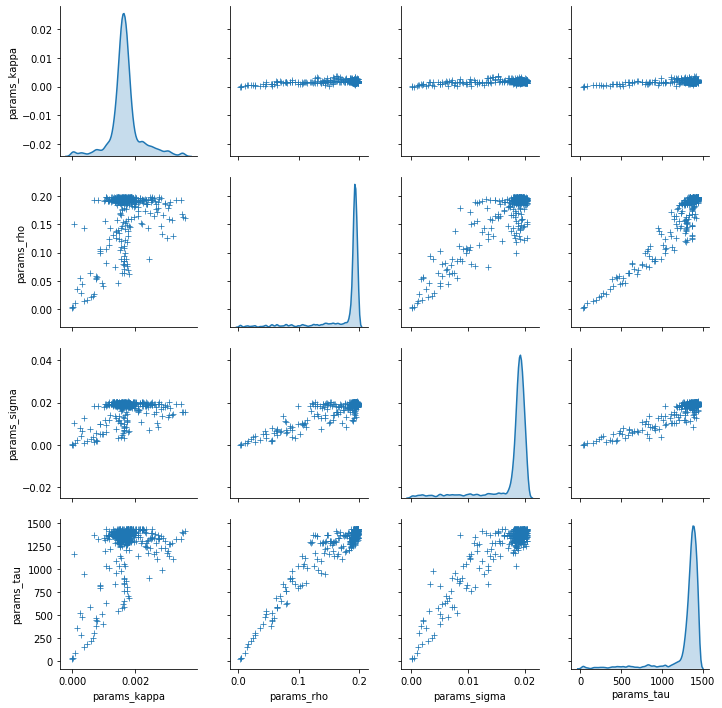

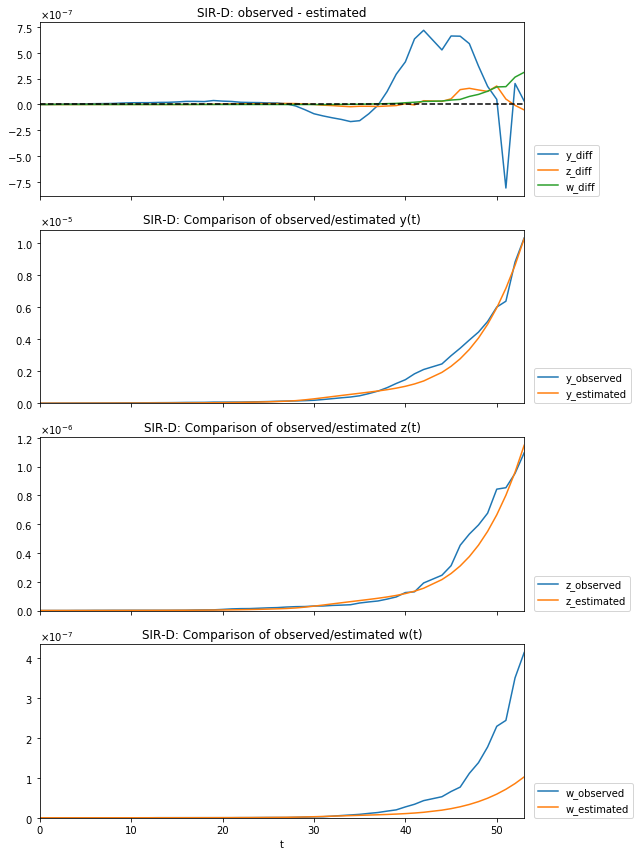

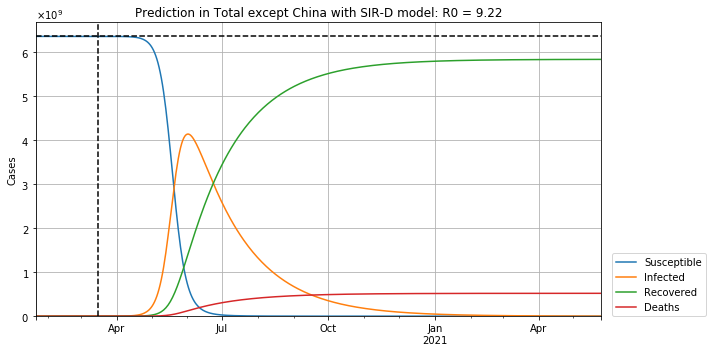

In [22]:
sird_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-D": sird_dict}, orient="index").fillna("-")
sird_estimater.compare_graph()
sird_estimater.predict_graph(step_n=500)

## Prediction with SIR-F model
Some cases are reported as fatal cases before clinical diagnosis of COVID-19. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model.

### What is SIR-F model?
* S: Susceptible
* S$^\ast$: Infected but un-confirmed
* I: Infected and confirmed
* R: Recovered
* F: Fatal

Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
S $\overset{\beta \mathrm{I}}{\longrightarrow}$ S$^\ast$ $\overset{\alpha_1}{\longrightarrow}$ F  
S $\overset{\beta \mathrm{I}}{\longrightarrow}$ S$^\ast$ $\overset{1 - \alpha_1}{\longrightarrow}$ I  
I $\overset{\gamma}{\longrightarrow}$ R  
I $\overset{\alpha_2}{\longrightarrow}$ F  

$\alpha_1$: Mortality rate of S$^\ast$ cases [-]  
$\alpha_2$: Mortality rate of I cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):   
$\frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I$  
$\frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I$  
$\frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I$  
$\frac{\mathrm{d}D}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I$  

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-F model
Set $(S, I, R, D) = N \times (x, y, z, z)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
$\frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y$  
$\frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y$  
$\frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y$  
$\frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y$  

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
$0 < (x, y, z, \theta, \kappa, \rho, \sigma) < 1$  
$1 \leq \tau \leq 1440$  

Reproduction number can be defined as  
$R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}$

### Hyperparameter optimization
Using Optuna package, ($\theta, \kappa, \rho, \sigma, \tau$) will be estimated by model fitting.

In [23]:
%%time
sirf_estimater = Estimater(
    SIRF, ncov_df, population_dict["Global"] - population_dict["China"],
    name="Total except China", excluded_places=[("China", None)]
)
sirf_dict = sirf_estimater.run()

[I 2020-03-16 00:43:36,505] Finished trial#0 resulted in value: 3560192458301.3296. Current best value is 3560192458301.3296 with parameters: {'tau': 838, 'theta': 0.8847362094902423, 'kappa': 0.4779554946536714, 'rho': 0.094831685376664, 'sigma': 0.004542544843062911}.
[I 2020-03-16 00:43:36,578] Finished trial#2 resulted in value: 6240220718983.232. Current best value is 3560192458301.3296 with parameters: {'tau': 838, 'theta': 0.8847362094902423, 'kappa': 0.4779554946536714, 'rho': 0.094831685376664, 'sigma': 0.004542544843062911}.
[I 2020-03-16 00:43:36,695] Finished trial#3 resulted in value: 4874128745267.869. Current best value is 3560192458301.3296 with parameters: {'tau': 838, 'theta': 0.8847362094902423, 'kappa': 0.4779554946536714, 'rho': 0.094831685376664, 'sigma': 0.004542544843062911}.
[I 2020-03-16 00:43:36,814] Finished trial#6 resulted in value: 11210099875842.71. Current best value is 3560192458301.3296 with parameters: {'tau': 838, 'theta': 0.8847362094902423, 'kappa

[I 2020-03-16 00:43:39,877] Finished trial#29 resulted in value: 146352775173.66245. Current best value is 145714344048.01385 with parameters: {'tau': 1307, 'theta': 0.8223044733363263, 'kappa': 0.07021816024830635, 'rho': 0.12053072261285029, 'sigma': 0.019544193113121774}.
[I 2020-03-16 00:43:40,040] Finished trial#30 resulted in value: 146488751470.77344. Current best value is 145714344048.01385 with parameters: {'tau': 1307, 'theta': 0.8223044733363263, 'kappa': 0.07021816024830635, 'rho': 0.12053072261285029, 'sigma': 0.019544193113121774}.
[I 2020-03-16 00:43:40,137] Finished trial#33 resulted in value: 1512335539098.7202. Current best value is 145714344048.01385 with parameters: {'tau': 1307, 'theta': 0.8223044733363263, 'kappa': 0.07021816024830635, 'rho': 0.12053072261285029, 'sigma': 0.019544193113121774}.
[I 2020-03-16 00:43:40,219] Finished trial#31 resulted in value: 2574667155238.0986. Current best value is 145714344048.01385 with parameters: {'tau': 1307, 'theta': 0.8223

[I 2020-03-16 00:43:43,589] Finished trial#59 resulted in value: 145433710157.83545. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:43,703] Finished trial#60 resulted in value: 146161212571.78452. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:43,896] Finished trial#58 resulted in value: 2637784578016.63. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:44,022] Finished trial#62 resulted in value: 150662369997.96472. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.735

[I 2020-03-16 00:43:47,392] Finished trial#87 resulted in value: 145820895738.17712. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:47,511] Finished trial#88 resulted in value: 199670877718.57596. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:47,696] Finished trial#89 resulted in value: 145570622829.1761. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.7356758667570038, 'kappa': 0.0037382206520834294, 'rho': 0.12855788978340174, 'sigma': 0.01940915384550945}.
[I 2020-03-16 00:43:47,787] Finished trial#90 resulted in value: 147268856438.02563. Current best value is 145433710157.83545 with parameters: {'tau': 1360, 'theta': 0.73

[I 2020-03-16 00:43:51,370] Finished trial#116 resulted in value: 145929702351.18716. Current best value is 144915930488.63266 with parameters: {'tau': 1331, 'theta': 0.9516967656920885, 'kappa': 0.025396423930683268, 'rho': 0.11568987850115973, 'sigma': 0.0192588851036479}.
[I 2020-03-16 00:43:51,529] Finished trial#118 resulted in value: 145266021592.13312. Current best value is 144915930488.63266 with parameters: {'tau': 1331, 'theta': 0.9516967656920885, 'kappa': 0.025396423930683268, 'rho': 0.11568987850115973, 'sigma': 0.0192588851036479}.
[I 2020-03-16 00:43:51,645] Finished trial#117 resulted in value: 149801264682.3325. Current best value is 144915930488.63266 with parameters: {'tau': 1331, 'theta': 0.9516967656920885, 'kappa': 0.025396423930683268, 'rho': 0.11568987850115973, 'sigma': 0.0192588851036479}.
[I 2020-03-16 00:43:51,799] Finished trial#120 resulted in value: 146146611380.5607. Current best value is 144915930488.63266 with parameters: {'tau': 1331, 'theta': 0.95169

[I 2020-03-16 00:43:55,122] Finished trial#143 resulted in value: 152925466872.4865. Current best value is 142935413182.17566 with parameters: {'tau': 1239, 'theta': 0.6728586758274225, 'kappa': 0.0025124194128330057, 'rho': 0.10839520017360002, 'sigma': 0.018740373163689848}.
[I 2020-03-16 00:43:55,313] Finished trial#145 resulted in value: 146488453500.9076. Current best value is 142935413182.17566 with parameters: {'tau': 1239, 'theta': 0.6728586758274225, 'kappa': 0.0025124194128330057, 'rho': 0.10839520017360002, 'sigma': 0.018740373163689848}.
[I 2020-03-16 00:43:55,408] Finished trial#147 resulted in value: 148047794998.65854. Current best value is 142935413182.17566 with parameters: {'tau': 1239, 'theta': 0.6728586758274225, 'kappa': 0.0025124194128330057, 'rho': 0.10839520017360002, 'sigma': 0.018740373163689848}.
[I 2020-03-16 00:43:55,596] Finished trial#149 resulted in value: 145273390619.15286. Current best value is 142935413182.17566 with parameters: {'tau': 1239, 'theta'

[I 2020-03-16 00:43:59,149] Finished trial#176 resulted in value: 142376545363.38797. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:43:59,249] Finished trial#175 resulted in value: 141398375063.39783. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:43:59,445] Finished trial#179 resulted in value: 142058239495.9685. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:43:59,610] Finished trial#173 resulted in value: 141638532478.31165. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 

[I 2020-03-16 00:44:03,325] Finished trial#204 resulted in value: 139991471505.75247. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:44:03,460] Finished trial#203 resulted in value: 3886148803988.3203. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:44:03,588] Finished trial#205 resulted in value: 141381544807.8427. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 0.5180338724740585, 'kappa': 0.00033249493275751957, 'rho': 0.0913128336940236, 'sigma': 0.01616263441361489}.
[I 2020-03-16 00:44:03,694] Finished trial#206 resulted in value: 141792933493.57373. Current best value is 138821752019.58984 with parameters: {'tau': 1189, 'theta': 

[I 2020-03-16 00:44:07,964] Finished trial#233 resulted in value: 145537550668.3917. Current best value is 138455323201.63507 with parameters: {'tau': 1161, 'theta': 0.4972484041517607, 'kappa': 8.379561306069584e-05, 'rho': 0.08846325907793845, 'sigma': 0.015253284946964318}.
[I 2020-03-16 00:44:08,118] Finished trial#232 resulted in value: 144054479676.4566. Current best value is 138455323201.63507 with parameters: {'tau': 1161, 'theta': 0.4972484041517607, 'kappa': 8.379561306069584e-05, 'rho': 0.08846325907793845, 'sigma': 0.015253284946964318}.
[I 2020-03-16 00:44:08,304] Finished trial#236 resulted in value: 142900965206.6348. Current best value is 138455323201.63507 with parameters: {'tau': 1161, 'theta': 0.4972484041517607, 'kappa': 8.379561306069584e-05, 'rho': 0.08846325907793845, 'sigma': 0.015253284946964318}.
[I 2020-03-16 00:44:08,509] Finished trial#235 resulted in value: 145079333287.1715. Current best value is 138455323201.63507 with parameters: {'tau': 1161, 'theta': 

[I 2020-03-16 00:44:13,127] Finished trial#260 resulted in value: 144567965186.5639. Current best value is 133980702248.98828 with parameters: {'tau': 946, 'theta': 0.27443436619867634, 'kappa': 0.0002890240394342941, 'rho': 0.08193780029435273, 'sigma': 0.013157754372339965}.
[I 2020-03-16 00:44:13,355] Finished trial#259 resulted in value: 136270798008.08871. Current best value is 133980702248.98828 with parameters: {'tau': 946, 'theta': 0.27443436619867634, 'kappa': 0.0002890240394342941, 'rho': 0.08193780029435273, 'sigma': 0.013157754372339965}.
[I 2020-03-16 00:44:13,465] Finished trial#265 resulted in value: 132513833189.20505. Current best value is 132513833189.20505 with parameters: {'tau': 962, 'theta': 0.25158398130787285, 'kappa': 0.0002224213637376357, 'rho': 0.07617770510057179, 'sigma': 0.012839349352031484}.
[I 2020-03-16 00:44:13,626] Finished trial#262 resulted in value: 144100504513.35437. Current best value is 132513833189.20505 with parameters: {'tau': 962, 'theta'

[I 2020-03-16 00:44:17,530] Finished trial#290 resulted in value: 132022658386.24358. Current best value is 131742984892.55698 with parameters: {'tau': 901, 'theta': 0.18937351933683122, 'kappa': 0.0007167382221672353, 'rho': 0.0781865964387321, 'sigma': 0.0083049670011387}.
[I 2020-03-16 00:44:17,681] Finished trial#292 resulted in value: 131597226884.21259. Current best value is 131597226884.21259 with parameters: {'tau': 805, 'theta': 0.20433786007238267, 'kappa': 3.6261107656853644e-05, 'rho': 0.07333445955368884, 'sigma': 0.009149795443372294}.
[I 2020-03-16 00:44:17,823] Finished trial#291 resulted in value: 134776010065.88547. Current best value is 131597226884.21259 with parameters: {'tau': 805, 'theta': 0.20433786007238267, 'kappa': 3.6261107656853644e-05, 'rho': 0.07333445955368884, 'sigma': 0.009149795443372294}.
[I 2020-03-16 00:44:18,017] Finished trial#293 resulted in value: 141641443131.94504. Current best value is 131597226884.21259 with parameters: {'tau': 805, 'theta'

[I 2020-03-16 00:44:22,700] Finished trial#320 resulted in value: 152732667732.22552. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:23,012] Finished trial#318 resulted in value: 153980872123.28418. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:23,014] Finished trial#321 resulted in value: 152457714868.64215. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:23,324] Finished trial#323 resulted in value: 156248726753.7506. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta'

[I 2020-03-16 00:44:28,425] Finished trial#347 resulted in value: 5912355188443.587. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:28,607] Finished trial#349 resulted in value: 2017281218047.6875. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:28,877] Finished trial#350 resulted in value: 147438202471.59866. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:29,061] Finished trial#352 resulted in value: 148699477757.5415. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta':

[I 2020-03-16 00:44:33,147] Finished trial#377 resulted in value: 146953258618.9356. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:33,374] Finished trial#378 resulted in value: 149026056574.57367. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:33,552] Finished trial#379 resulted in value: 129174420344.68039. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:33,699] Finished trial#380 resulted in value: 149410936828.09506. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta'

[I 2020-03-16 00:44:38,366] Finished trial#406 resulted in value: 143451764343.60037. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:38,500] Finished trial#408 resulted in value: 117278710832.8028. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:38,620] Finished trial#407 resulted in value: 3980702767717.9277. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta': 0.01646126964109404, 'kappa': 0.0028579864405540037, 'rho': 0.07482542974525463, 'sigma': 0.008529977229730585}.
[I 2020-03-16 00:44:38,835] Finished trial#409 resulted in value: 141300047349.48795. Current best value is 104992295594.56853 with parameters: {'tau': 644, 'theta'

[I 2020-03-16 00:44:43,691] Finished trial#435 resulted in value: 142766829741.57803. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:43,915] Finished trial#436 resulted in value: 141177538110.83173. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:44,178] Finished trial#437 resulted in value: 151799811040.65253. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:44,262] Finished trial#438 resulted in value: 120095162483.18095. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'the

[I 2020-03-16 00:44:49,119] Finished trial#465 resulted in value: 146844410858.77515. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:49,323] Finished trial#466 resulted in value: 121419139453.92229. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:49,484] Finished trial#467 resulted in value: 145442544081.5795. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:49,646] Finished trial#468 resulted in value: 152480155336.1307. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta

[I 2020-03-16 00:44:54,343] Finished trial#493 resulted in value: 148804905730.4912. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:54,473] Finished trial#494 resulted in value: 141700270921.08942. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:54,604] Finished trial#495 resulted in value: 149104355208.77066. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'theta': 0.011069606994659897, 'kappa': 0.00014281819745178595, 'rho': 0.07181904665018662, 'sigma': 0.008345319955716005}.
[I 2020-03-16 00:44:54,919] Finished trial#499 resulted in value: 114515514552.46907. Current best value is 85840934922.53056 with parameters: {'tau': 602, 'thet

CPU times: user 1min 19s, sys: 4.17 s, total: 1min 23s
Wall time: 1min 18s


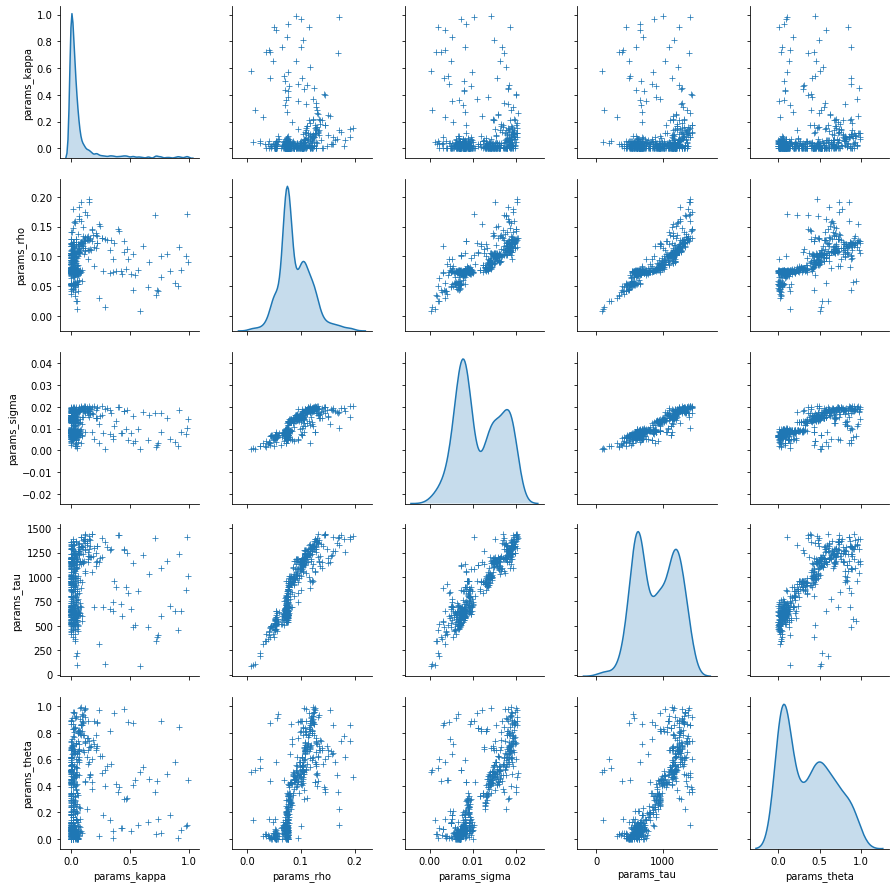

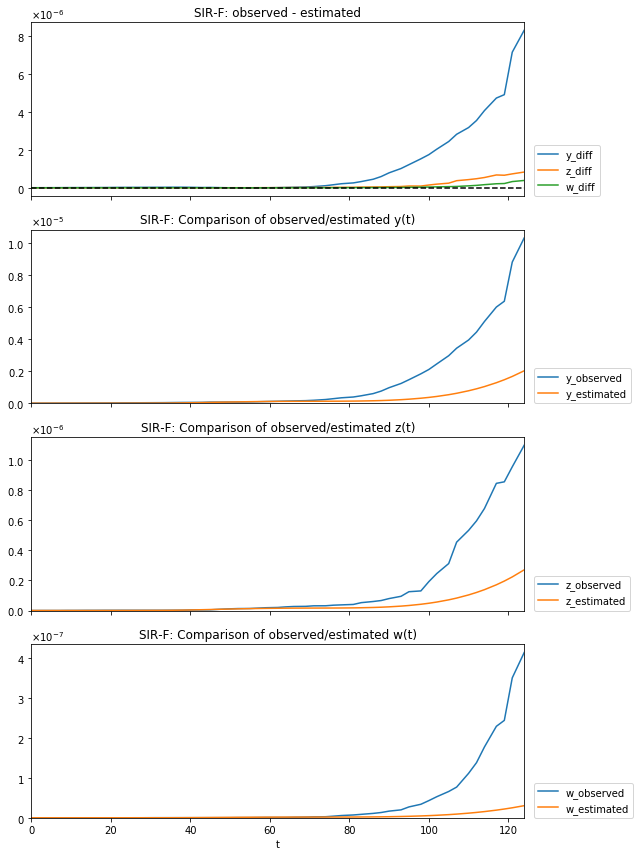

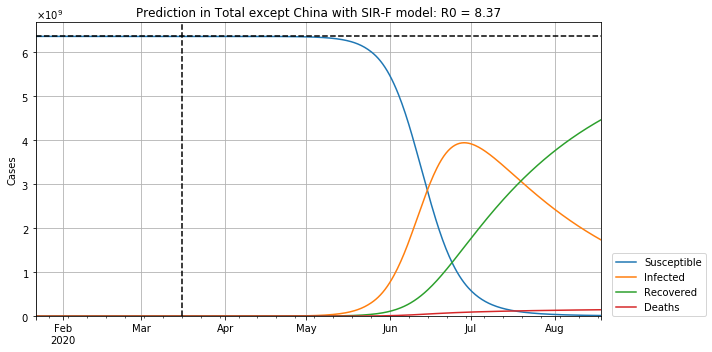

In [24]:
sirf_estimater.history_df().head()
sirf_estimater.history_graph()
pd.DataFrame.from_dict({"SIR": sir_dict, "SIR-F": sirf_dict}, orient="index").fillna("-")
sirf_estimater.compare_graph()
sirf_estimater.predict_graph(step_n=500)